# Analysis of YY1, YY2, and THAP11 TFs
### Author: Martin Loza
### Date: 25/02/12

On this notebook I will explore the relationship between the core promoters of HKG and those of ZNF genes. At the beggining I would perform a general analysis and bit by bit start going into the complex structured core promoters.

It's been reported that HKG would be enriched in THAP11 and cell types specific genes would be enriched in YY1. According to my analysis, this is only true for ZNFG with a HK-CPs, and HKG would be also enriched in YY2 (paralog of YY1). 

I downloaded ChIP-seq data for these three factors from the HEK293 cell line. I hope to find some differences on their enrichement.

In [96]:
#Init
Sys.setenv(LANG = "en") 
library(dplyr)
library(ggplot2) 
library(stringr)
library(GenomicRanges)
library(tidyr)
library(patchwork)

#Global variables
tf_dir = "~/Documents/Projects/HK_Interactions/Analysis/thisWeek/2025_02_18/HEK293/"
# cp_dir = "/Volumes/HK_CP_DATA/Data/Annotations_CREs/CP_genes/"
out_dir = "~/Documents/Projects/HK_Interactions/Analysis/2025_02/2025_02_18/HK_CP/Results/"
date = "250212"
seed = 777

# Global functions

# Function to create GRanges object from a data frame
create_granges <- function(regions_df, chr_column = "chr", start_column = "start", end_column = "end", retain_md = TRUE) {
    # Create a GRanges object from a data frame
    gr <- GRanges(seqnames = regions_df[[chr_column]],
                                ranges = IRanges(start = regions_df[[start_column]], end = regions_df[[end_column]]),)
    # Retain metadata columns
    if (retain_md) {
        mcols(gr) <- regions_df[, !(names(regions_df) %in% c("chr", "start", "end"))]
    }
    return(gr)
}

analyze_gr <- function(gr, binwidth = 0.1) {

    # as data frame
    gr_df <- as.data.frame(gr)    
      
    # Calculate main statistics
    stats <- gr_df %>% 
        summarise(
            min = min(width),
            q1 = quantile(width, 0.25),
            median = median(width),
            mean = mean(width),
            q3 = quantile(width, 0.75),
            max = max(width),
            count = n()
        )
    
    # Plot the distribution of the gaps length
    gr_df %>% 
        ggplot(aes(x = width)) +
        geom_histogram(binwidth = binwidth, fill = "#dad8d8bd", color = "black") +
        theme_light() +
        scale_x_log10(labels = scales::comma) +
        theme(text = element_text(size = 12)) +
        annotate("text", x = Inf, y = Inf, 
                label = paste("Count:", stats$count, 
                "\nMin:", stats$min,
                 "\nQ1:", stats$q1,
                "\nMedian:", stats$median,
                 "\nMean:", round(stats$mean, 2),
                  "\nQ3:", stats$q3,
                   "\nMax:", stats$max), 
                 hjust = 1.1, vjust = 1.1, size = 3, color = "blue", parse = FALSE)
}

## Setup the TF data

This are just example data. ATAC peaks for open chromatin and H3K427ac for activity marks


In [114]:
h3k27ac <- read.csv2(file = paste0(tf_dir, "SRX080331.05.bed"), sep = "\t", header = FALSE)
atac <- read.csv2(file = paste0(tf_dir, "SRX9486248.05.bed"), sep = "\t", header = FALSE)

# rename columns
col_names <- c("chr", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak")
colnames(h3k27ac) <- col_names
colnames(atac) <- col_names

# set the signalValue, pValue, and qValue as numeric
atac[, c("signalValue", "pValue", "qValue")] <- lapply(atac[, c("signalValue", "pValue", "qValue")], as.numeric)
h3k27ac[, c("signalValue", "pValue", "qValue")] <- lapply(h3k27ac[, c("signalValue", "pValue", "qValue")], as.numeric)

# select only regions of chromosomes of interest
sel_chr <- paste0("chr", c(1:22, "X"))
atac <- atac %>% filter(chr %in% sel_chr)
h3k27ac <- h3k27ac %>% filter(chr %in% sel_chr)

rm(col_names)

Short test for the minimum qvalue

In [115]:
expected_min_qvalue <- -log10(1e-5)
cat("All qValues are greater than expected in the atac dataset: ", all(atac$qValue > expected_min_qvalue), "\n")
cat("All qValues are greater than expected in the h3k27ac dataset: ", all(h3k27ac$qValue > expected_min_qvalue), "\n")


rm(expected_min_qvalue)

All qValues are greater than expected in the atac dataset:  TRUE 
All qValues are greater than expected in the h3k27ac dataset:  TRUE 


In [116]:

cat("Number of peaks in the atac dataset: ", nrow(atac), "\n")
cat("Number of peaks in the h3k27ac dataset: ", nrow(h3k27ac), "\n")

Number of peaks in the atac dataset:  16492 
Number of peaks in the h3k27ac dataset:  63746 


This is just an example data. In reality I wouldn't expect so many peaks for the activity mark.

#### Peaks and gaps analysis

Let's analyse the peaks and gaps distributions

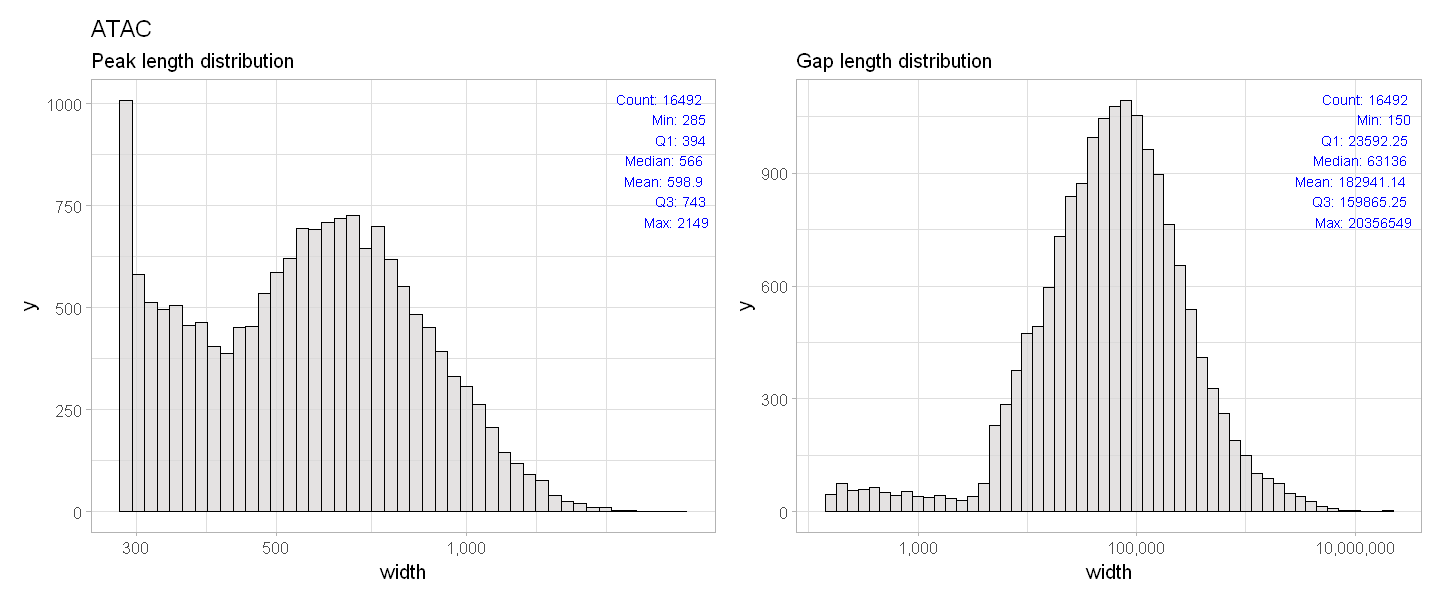

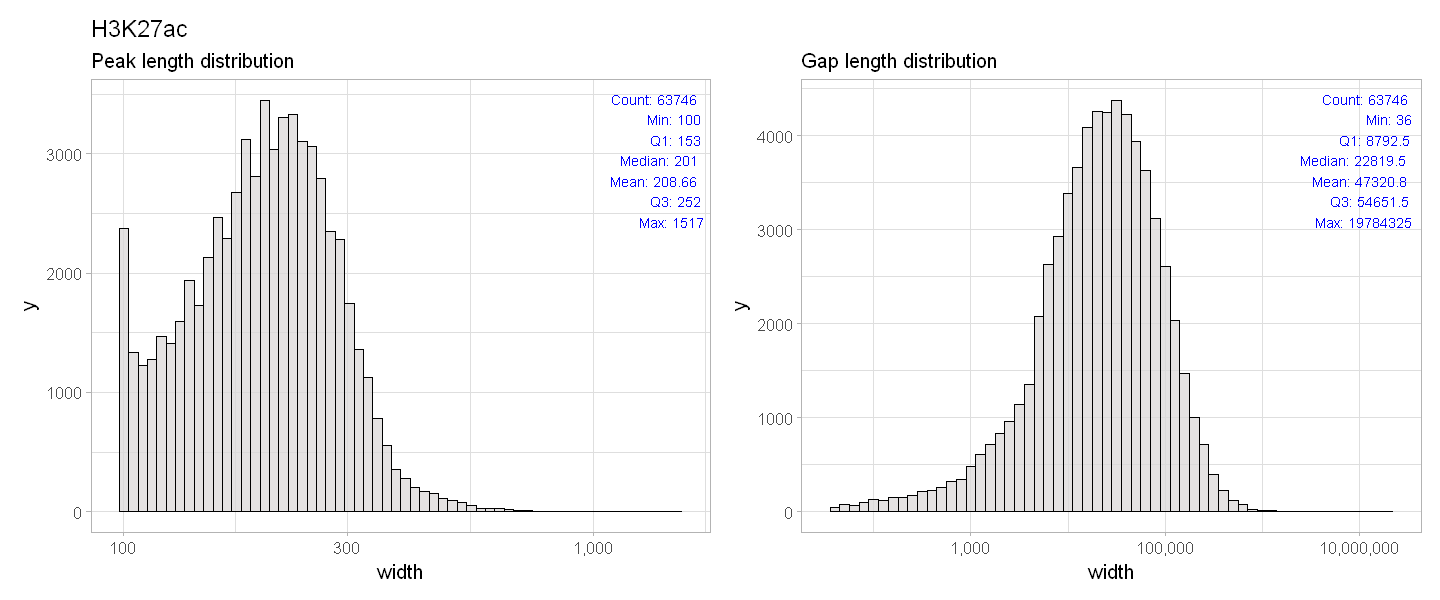

In [117]:
# change figure size
options(repr.plot.width=12, repr.plot.height=5)

atac_gr <- create_granges(atac, retain_md = FALSE)
p1 <- analyze_gr(gr = atac_gr, binwidth = 0.02) + ggtitle("ATAC",subtitle = "Peak length distribution")
p2 <- analyze_gr(gr = gaps(atac_gr)) + ggtitle(label = "",subtitle = "Gap length distribution")
p1 + p2

h3k27ac_gr <- create_granges(h3k27ac, retain_md = FALSE)
p3 <- analyze_gr(gr = h3k27ac_gr, binwidth = 0.02) + ggtitle("H3K27ac",subtitle = "Peak length distribution")
p4 <- analyze_gr(gr = gaps(h3k27ac_gr)) + ggtitle(label = "",subtitle = "Gap length distribution")
p3 + p4


Specifically for the H3K27ac we see some gaps smaller than 500 bps, we would like to merge close regions.

In [118]:
min_gap = 500
# add 100bps to each side of the peak
atac_gr <- atac_gr + min_gap
h3k27ac_gr <- h3k27ac_gr + min_gap
# merge overlapping regions
atac_gr <- reduce(atac_gr)
h3k27ac_gr <- reduce(h3k27ac_gr)
# substract the 100bp to each side of the peak
atac_gr <- atac_gr - min_gap
h3k27ac_gr <- h3k27ac_gr - min_gap

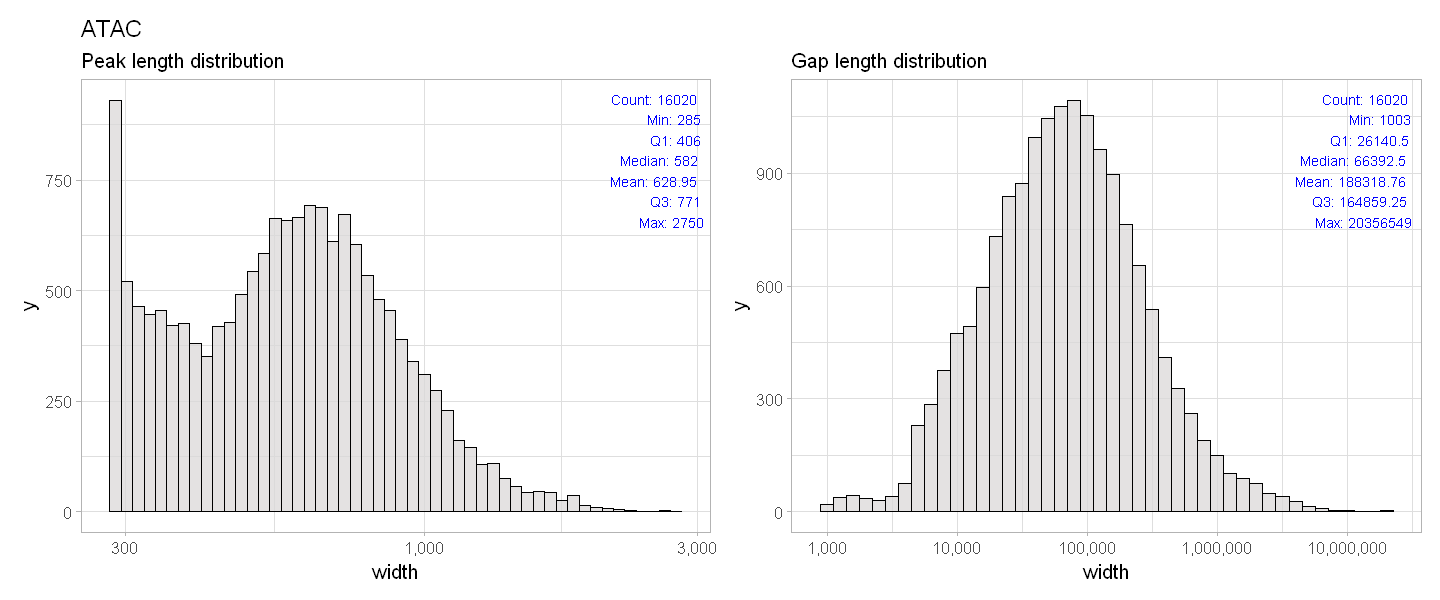

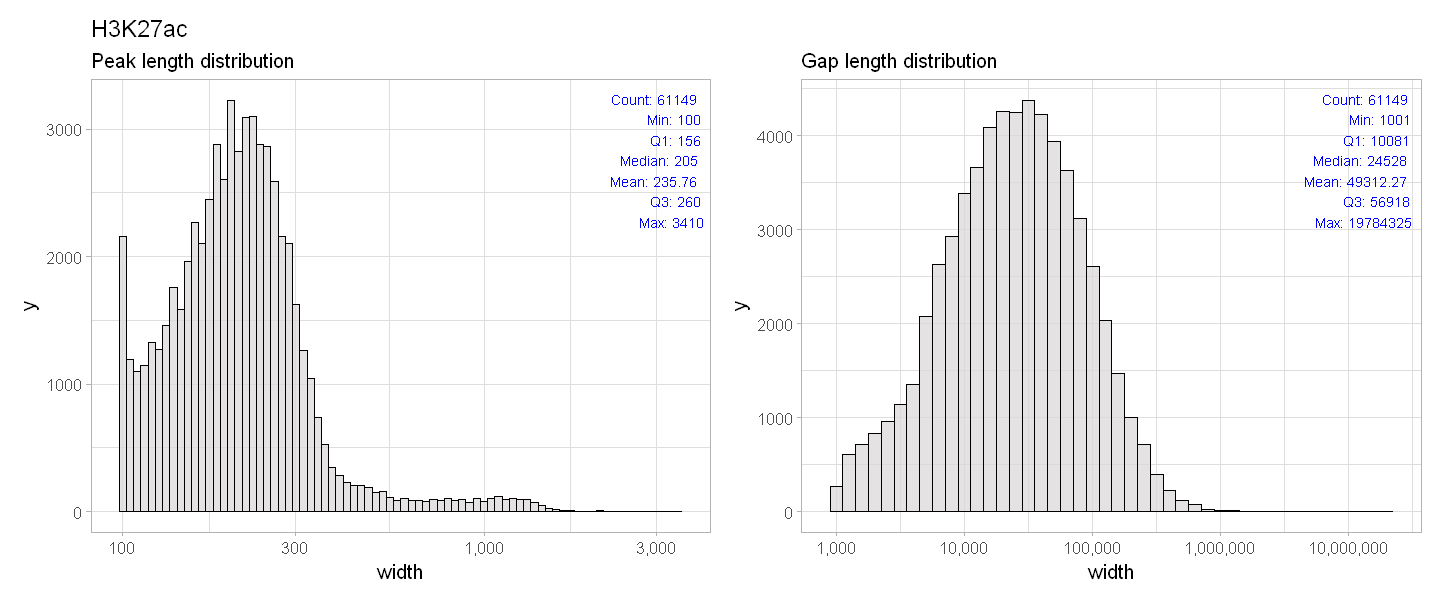

In [119]:
# change figure size
options(repr.plot.width=12, repr.plot.height=5)

p1 <- analyze_gr(gr = atac_gr, binwidth = 0.02) + ggtitle("ATAC",subtitle = "Peak length distribution")
p2 <- analyze_gr(gr = gaps(atac_gr)) + ggtitle(label = "",subtitle = "Gap length distribution")
p1 + p2

p3 <- analyze_gr(gr = h3k27ac_gr, binwidth = 0.02) + ggtitle("H3K27ac",subtitle = "Peak length distribution")
p4 <- analyze_gr(gr = gaps(h3k27ac_gr)) + ggtitle(label = "",subtitle = "Gap length distribution")
p3 + p4


Now the gaps are all longer than 100 bps. 

Finally, we would like to retain only ATAC peaks (open chromatin) with activity marks. We are not interested on inactive regions for now. 

In [120]:
# find overlapping between atac and h3k27ac
ovl <- findOverlaps(atac_gr, h3k27ac_gr) 
# get the indices of atac peaks with overlapping activity marks
atac_idx <- queryHits(ovl)
# select unique indices
atac_idx <- unique(atac_idx)
# select the atac peaks with overlapping activity marks
sel_atac <- atac_gr[atac_idx]

head(sel_atac)


GRanges object with 6 ranges and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1   629539-632226      *
  [2]     chr1   633854-634218      *
  [3]     chr1   778375-779198      *
  [4]     chr1   869753-870178      *
  [5]     chr1   976010-976586      *
  [6]     chr1 1059056-1059483      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [121]:
sel_atac_df <- as.data.frame(sel_atac)

Warning message in geom_histogram(stat = "count"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"
Warning message in geom_histogram(stat = "count"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


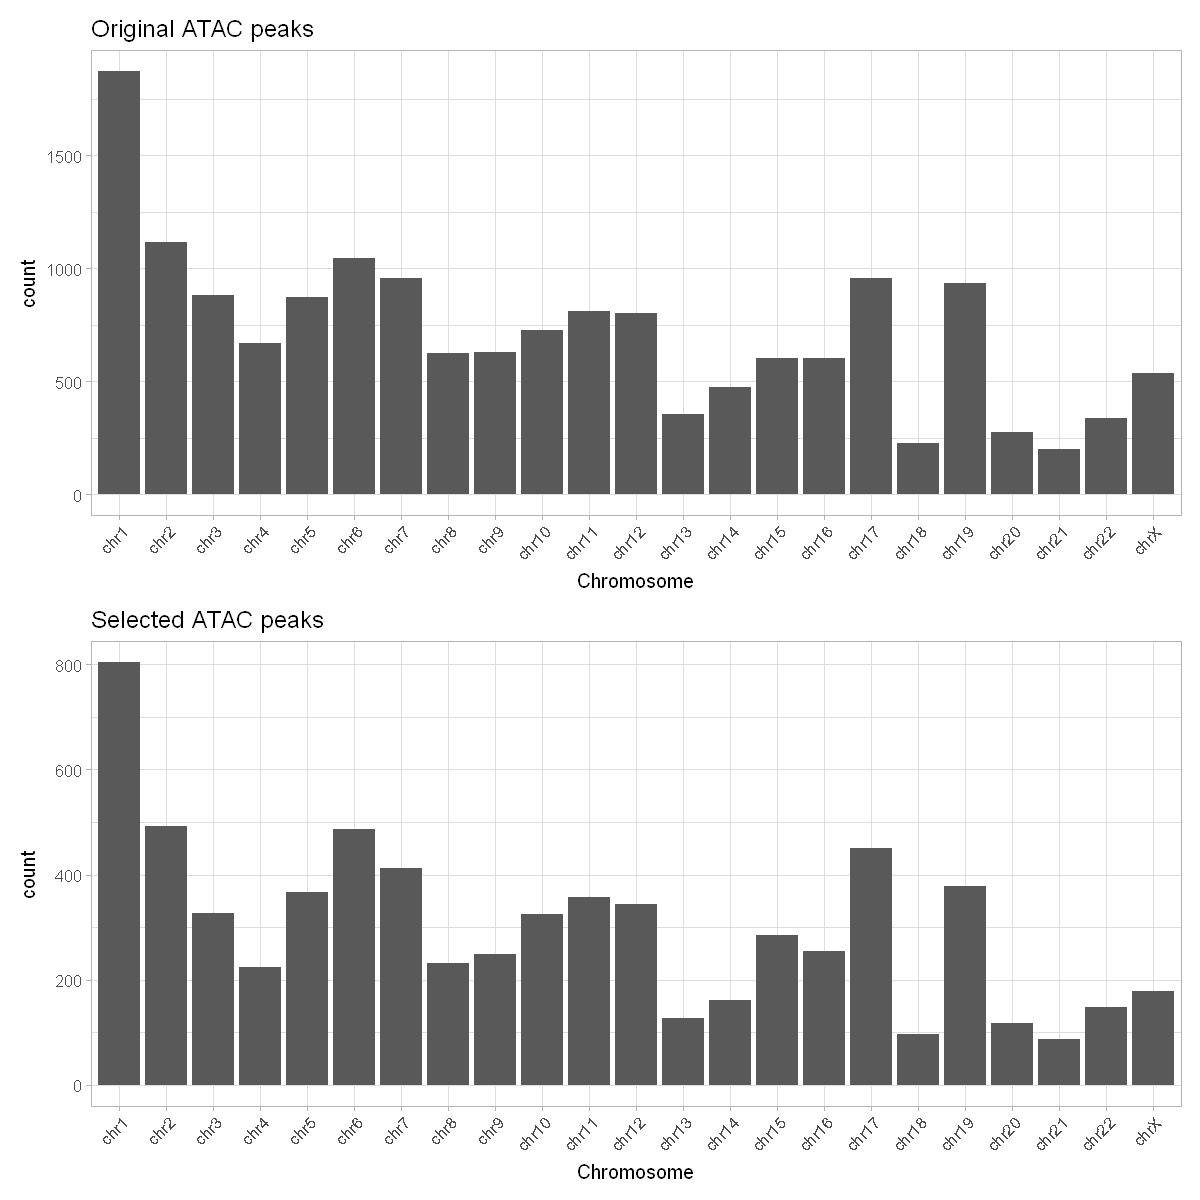

In [128]:
# compare original and selected atac peaks

p1 <- atac %>% 
    mutate(chr = factor(chr, levels = sel_chr)) %>%
    ggplot(aes(x = chr)) +
    geom_histogram(stat = "count") +
    ggtitle("Original ATAC peaks") +
    xlab("Chromosome") +
    theme_light() +
    theme(text = element_text(size = 12), axis.text.x = element_text(angle = 45, hjust = 1))

p2 <- sel_atac_df %>% 
    mutate(seqnames = factor(seqnames, levels = sel_chr)) %>%
    ggplot(aes(x = seqnames)) +
    geom_histogram(stat = "count") +
    ggtitle("Selected ATAC peaks") +
    xlab("Chromosome") +
    theme_light() +
    theme(text = element_text(size = 12), axis.text.x = element_text(angle = 45, hjust = 1))

# change figure size
options(repr.plot.width=10, repr.plot.height=10)
p1/p2